  Evaluated 50 individuals
-- Generation 1 --
-- Generation 2 --
-- Generation 3 --
-- Generation 4 --
-- Generation 5 --
-- Generation 6 --
-- Generation 7 --
-- Generation 8 --
-- Generation 9 --
-- Generation 10 --
  Min 0.8158912415044816
  Max 1.4186262190465535
  Avg 1.187517560183352
  Std 0.14997647454327778
-- Generation 11 --
-- Generation 12 --
-- Generation 13 --
-- Generation 14 --
-- Generation 15 --
-- Generation 16 --
-- Generation 17 --
-- Generation 18 --
-- Generation 19 --
-- Generation 20 --
  Min 0.03123783003654851
  Max 1.441635057299501
  Avg 1.2638641349316302
  Std 0.19053263045350102
-- Generation 21 --
-- Generation 22 --
-- Generation 23 --
-- Generation 24 --
-- Generation 25 --
-- Generation 26 --
-- Generation 27 --
-- Generation 28 --
-- Generation 29 --
-- Generation 30 --
  Min 1.1428325730796318
  Max 1.4417517457121358
  Avg 1.3680875750660761
  Std 0.06940350495867409
-- Generation 31 --
-- Generation 32 --
-- Generation 33 --
-- Generation 34 --


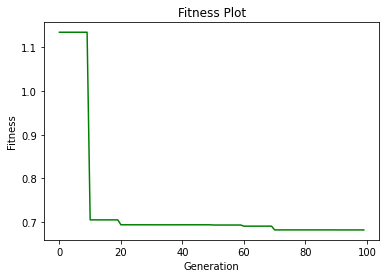

In [3]:
import random
from sympy.combinatorics.graycode import GrayCode
from sympy.combinatorics.graycode import gray_to_bin
from deap import creator, base, tools, algorithms
import numpy as np
import matplotlib.pyplot as plt

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

popSize     = 50 #Population size
dimension   = 2 #Number of decision variable x 
numOfBits   = 30 #Number of bits in the chromosomes
iterations  = 100 #Number of generations to be run
dspInterval = 10
nElitists   = 1 #number of elite individuals selected
omega       = 5
crossPoints = 2 #variable not used. instead tools.cxTwoPoint
crossProb   = 0.6
flipProb    = 1. / (dimension * numOfBits) #bit mutate prob
mutateprob  = .1 #mutation prob
maxnum      = 2**numOfBits #absolute max size of number coded by binary list 1,0,0,1,1,....


toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, 
    toolbox.attr_bool, numOfBits*dimension)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def eval_sphere(individual):
    sep=separatevariables(individual)
    f = 2+(4.1*sep[0]**2)-(2.1*sep[0]**4)+(1/3)*(sep[0]**6)+(sep[0]*sep[1])-(4*(sep[1]-0.05)**2)+(4*sep[1]**4) 
    return 1.0/(0.01+f), 
#----------
# Operator registration
#----------
# register the goal / fitness function
toolbox.register("evaluate", eval_sphere)

# register the crossover operator
toolbox.register("mate", tools.cxTwoPoint)

# register a mutation operator with a probability to
# flip each attribute/gene of 0.05
toolbox.register("mutate", tools.mutFlipBit, indpb=flipProb)

# operator for selecting individuals for breeding the next
# generation: This uses fitness proportionate selection,
# also known as roulette wheel selection
toolbox.register("select", tools.selRoulette, fit_attr='fitness')

#----------

# Convert chromosome to real number
# input: list binary 1,0 of length numOfBits representing number using gray coding
# output: real value
def chrom2real(c):
    indasstring=''.join(map(str, c))
    degray=gray_to_bin(indasstring)
    numasint=int(degray, 2) # convert to int from base 2 list
    numinrange=-5+10*numasint/maxnum
    return numinrange

# input: concatenated list of binary variables
# output: tuple of real numbers representing those variables
def separatevariables(v):
    return chrom2real(v[0:numOfBits]),chrom2real(v[numOfBits:])

plfits = []  #list of fitness values inversed to minimisation values from maximisation
betters = [] # list of individuals with the best fitness in each generation

def main():

    # create an initial population of individuals (where
    # each individual is a list of integers)
    pop = toolbox.population(n=popSize)
    

    # Evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, pop))
    #print(fitnesses)
    for ind, fit in zip(pop, fitnesses):
        #print(ind, fit)
        ind.fitness.values = fit
    
    print("  Evaluated %i individuals" % len(pop))

    # Extracting all the fitnesses of 
    fits = [ind.fitness.values[0] for ind in pop]

    # Variable keeping track of the number of generations
    g = 0
    
    # Begin the evolution
    while g < iterations:
        # A new generation
        g = g + 1
        print("-- Generation %i --" % g)

        
        # Select the next generation individuals
        offspring = tools.selBest(pop, nElitists) + toolbox.select(pop,len(pop)-nElitists)
        good_ind = tools.selBest(pop, 1)[0]
        betters.append(separatevariables(good_ind))
        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))
        

    
        # Apply crossover and mutation on the offspring
        # make pairs of offspring for crossing over
        for child1, child2 in zip(offspring[::2], offspring[1::2]):

            # cross two individuals with probability CXPB
            if random.random() < crossProb:
                #print('before crossover ',child1, child2)
                toolbox.mate(child1, child2)
                #print('after crossover ',child1, child2)

                # fitness values of the children
                # must be recalculated later
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:

            # mutate an individual with probability mutateprob
            if random.random() < mutateprob:
                toolbox.mutate(mutant)
                del mutant.fitness.values
    
        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        
        
        # The population is entirely replaced by the offspring
        pop[:] = offspring
        plfits.append(1/max(fits))
        
        if g%dspInterval ==0:
            # Gather all the fitnesses in one list and print the stats
            fits = [ind.fitness.values[0] for ind in pop]

            length = len(pop)
            mean = sum(fits) / length
            sum2 = sum(x*x for x in fits)
            std = abs(sum2 / length - mean**2)**0.5

            print("  Min %s" % min(fits))
            print("  Max %s" % max(fits))
            print("  Avg %s" % mean)
            print("  Std %s" % std)
            
    
    print("-- End of (successful) evolution --")
    
    best_ind = tools.selBest(pop, 1)[0]
    print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values[0]**(-1)))
    print("Decoded x1, x2 is %s, %s" % (separatevariables(best_ind)))
    plt.plot(np.arange(0,100),plfits,'g-')
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title("Fitness Plot")
    plt.show()
    

if __name__ == "__main__":
    main()

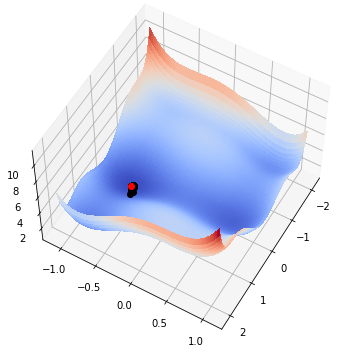

In [4]:
from pylab import *

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d.axes3d import Axes3D

def f(x1,x2):
    z = 2+(4.1*x1**2)-(2.1*x1**4)+(1/3*x1**6)+(x1*x2)-(4*(x2-0.05)**2)+(4*x2**4)
    return z
xrange = np.linspace(-2.1, 2.1, 100)
yrange = np.linspace(-1.1, 1.1, 100)
X,Y = np.meshgrid(xrange, yrange)
Z = f(X, Y)

xlist, ylist = map(list, zip(*betters))
zlist = []
for i in range(100):
    zlist.append(f(xlist[i],ylist[i]))
    
fig = plt.figure(figsize=(26,6))

ax = fig.add_subplot(1, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm, linewidth=0, antialiased=False, zorder=0)
ax.plot3D(xlist, ylist, zlist, color="k", marker='o', zorder=10)
ax.plot3D(xlist[99], ylist[99], zlist[99], color="r", marker='o', zorder=10)
ax.view_init(55, 30)

/var/folders/35/1fx3y5q15ss9928kg2045hfw0000gn/T/ipykernel_10511/1788107311.py:44: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cb = fig.colorbar(p, shrink=0.5)


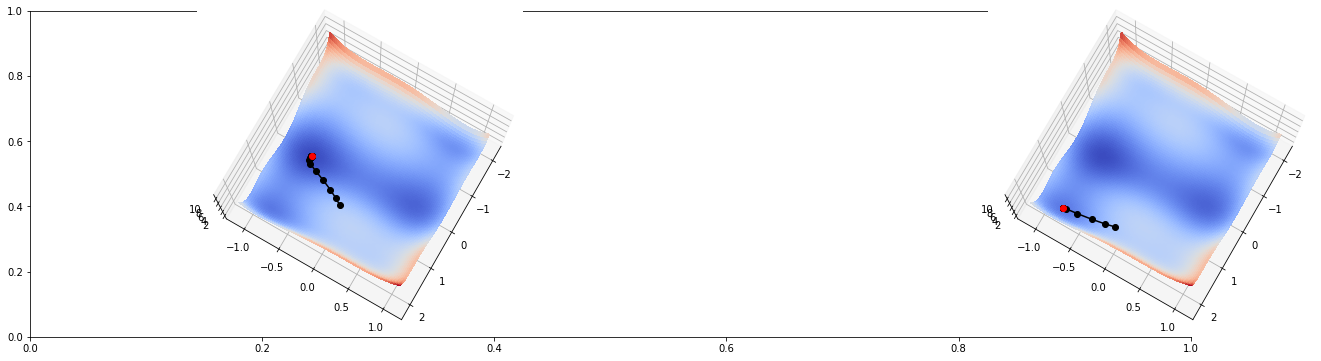

In [5]:
from pylab import *

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d.axes3d import Axes3D

def f(x1,x2):
    z=2+(4.1*x1**2)-(2.1*x1**4)+(1/3*x1**6)+(x1*x2)-(4*(x2-0.05)**2)+(4*x2**4)
    return z

xrange = np.linspace(-2.1,2.1,100)
yrange = np.linspace(-1.1,1.1,100)
X,Y = np.meshgrid(xrange, yrange)
Z = f(X, Y)

def dx1(x1,x2):
    return 8.2*x1-(8.4*x1**3)+(2*x1**5)+x2

def dx2(x1,x2):
    return x1-8*(x2-0.05)+16*x2**3

x1 = 1    #first initialising point (x1)
x2 = 0    #first initialising point (x2)

xlist=[]  #values of x1 for consecutive steps of gradient descent
ylist=[]  #values of x2 for consecutive steps of gradient descent
zlist=[]  #list of objective values of minimisation function
alpha=0.05

for step in range(0,30):
    newx1=x1-alpha*(dx1(x1,x2))
    x2=x2-alpha*(dx2(x1,x2))
    x1=newx1
    z=f(x1,x2)
    xlist.append(x1)
    ylist.append(x2)
    zlist.append(z)

fig = plt.figure(figsize=(26,6))

# surface_plot with color grading and color bar
cb = fig.colorbar(p, shrink=0.5)

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm, linewidth=0, antialiased=False, zorder=0)
ax.plot3D(xlist, ylist,zlist, color="k", marker='o', zorder=10)
ax.plot3D(xlist[29], ylist[29], zlist[29], color="r", marker='o', zorder=10)
ax.view_init(80, 30)
    
x1 = 1.5  #second initialising point (x1)
x2 = 0    #second initialising point (x2)
xlist1=[]
ylist1=[]
zlist1=[]
alpha=0.05

for step in range(0,30):
    newx1=x1-alpha*(dx1(x1,x2))
    x2=x2-alpha*(dx2(x1,x2))
    x1=newx1
    z=f(x1,x2)
    xlist1.append(x1)
    ylist1.append(x2)
    zlist1.append(z)

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm, linewidth=0, antialiased=False, zorder=0)
ax.plot3D(xlist1, ylist1,zlist1, color="k", marker='o', zorder=10)
ax.plot3D(xlist1[29], ylist1[29], zlist1[29], color="r", marker='o', zorder=10)
ax.view_init(80, 30)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Particle' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	evals	avg     	std    	min     	max    
0  	50   	-1.92963	858.885	-1559.62	2151.52
10 	50   	-124.402	854.399	-1760.18	1757.83
20 	50   	-136.842	923.102	-1918.1 	1591.37
30 	50   	-163.425	956.573	-2129.96	1997.14
40 	50   	-180.71 	916.41 	-2131.65	1668.81
50 	50   	-188.931	831.87 	-2131.66	1632.91
60 	50   	-167.608	721.936	-2131.66	1536.42
70 	50   	-220.919	638.505	-2131.66	1293.08
80 	50   	-296.647	690.876	-2131.66	1219.22
90 	50   	-345.938	690.16 	-2131.66	1130.73
100	50   	-387.339	663.598	-2131.66	892.138
110	50   	-482.663	704.556	-2131.66	881.94 
120	50   	-470.481	714.822	-2131.66	1166.69
130	50   	-451.953	666.036	-2131.66	884.16 
140	50   	-464.496	701.342	-2131.66	922.727
150	50   	-467.151	688.3  	-2131.66	743.6  
160	50   	-487.841	683.538	-2131.66	784.702
170	50   	-508.446	647.616	-2131.66	609.878
180	50   	-499.275	651.335	-2131.66	648.305
190	50   	-526.37 	662.058	-2131.66	667.093
200	50   	-545.564	679.832	-2131.66	764.24 
210	50   	-544.14 	708.508	-2131

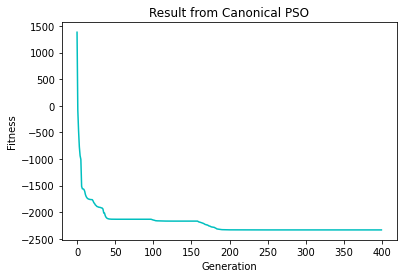

In [219]:
import operator
import random
import numpy
import math
from deap import base
from deap import benchmarks
from deap import creator
from deap import tools
import numpy as np
import matplotlib.pyplot as plt

posMinInit      = -500     #limits of particle position
posMaxInit      = +500     #limits of particle position
VMaxInit        = 1.5
VMinInit        = 0.5
populationSize  = 50
dimension       = 20
interval        = 10
iterations      = 400 

#Parameter setup

wmax = 0.9 #weighting
wmin = 0.4 
c1   = 2.0
c2   = 2.0

creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) # -1 is for minimise
creator.create("Particle", list, fitness=creator.FitnessMin, speed=list, smin=None, smax=None, best=None)
# particle rerpresented by list of 5 things
# 1. fitness of the particle, 
# 2. speed of the particle which is also going to be a list, 
# 3.4. limit of the speed value, 
# 5. best state the particle has been in so far.

def generate(size, smin, smax):
    part = creator.Particle(random.uniform(posMinInit, posMaxInit) for _ in range(size)) 
    part.speed = [random.uniform(VMinInit, VMaxInit) for _ in range(size)]
    part.smin = smin #speed clamping values
    part.smax = smax
    return part



def updateParticle(part, best, weight):
    #implementing speed = 0.7*(weight*speed + c1*r1*(localBestPos-currentPos) + c2*r2*(globalBestPos-currentPos))

    r1 = (random.uniform(0, 1) for _ in range(len(part)))
    r2 = (random.uniform(0, 1) for _ in range(len(part)))

    v_r0 = [weight*x for x in part.speed]
    v_r1 = [c1*x for x in map(operator.mul, r1, map(operator.sub, part.best, part))] # local best
    v_r2 = [c2*x for x in map(operator.mul, r2, map(operator.sub, best, part))] # global best
    
    part.speed = [0.7*x for x in map(operator.add, v_r0, map(operator.add, v_r1, v_r2))]


    #clamp limits
    for i, speed in enumerate(part.speed):
        if abs(speed) < part.smin:
            part.speed[i] = math.copysign(part.smin, speed)
        elif abs(speed) > part.smax:
            part.speed[i] = math.copysign(part.smax, speed)
            
    # update position with speed
    part[:] = list(map(operator.add, part, part.speed))

def eval_func(part):
    f=0
    for i in range(dimension):
        f+=(part[i]*math.sin(math.sqrt(abs(part[i]))))
    return (-f,)
                                        
toolbox = base.Toolbox()
toolbox.register("particle", generate, size=dimension, smin=-3, smax=3)
toolbox.register("population", tools.initRepeat, list, toolbox.particle)
toolbox.register("update", updateParticle)
toolbox.register("evaluate", eval_func)

fitpar = [] #list of fitness values of best particle



def main():
    pop = toolbox.population(n=populationSize) # Population Size
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("std", numpy.std)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)

    logbook = tools.Logbook()
    logbook.header = ["gen", "evals"] + stats.fields

    best = None

    #begin main loop
    for g in range(iterations):
        w = wmax - (wmax-wmin)*g/iterations #decaying inertia weight
        
        for part in pop:
            part.fitness.values = toolbox.evaluate(part) #actually only one fitness value
            
            #update local best
            if (not part.best) or (part.best.fitness < part.fitness):   #lower fitness is better (minimising)
            #   best is None   or  current value is better              #< is overloaded        
                part.best = creator.Particle(part)
                part.best.fitness.values = part.fitness.values
            
            #update global best
            if (not best) or best.fitness < part.fitness:
                best = creator.Particle(part)
                best.fitness.values = part.fitness.values
                fitpar.append(best.fitness.values)
                
        for part in pop:
            toolbox.update(part, best,w)

        # Gather all the fitnesses in one list and print the stats
        # print every interval
        if g%interval==0: # interval
            logbook.record(gen=g, evals=len(pop), **stats.compile(pop))
            print(logbook.stream)
    print('Best fitness is ',best.fitness)
    for i in range(400-len(fitpar)):
        fitpar.append(fitpar[len(fitpar)-1])
    print('best particle position is ',best)
    plt.plot(np.arange(0,iterations),fitpar[:400],'c-')
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title("Result from Canonical PSO")
    return pop, logbook, best

if __name__ == "__main__":
    main()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Particle' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	evals	avg   	std   	min     	max    
0  	102  	5.0985	797.02	-2149.19	1853.68
10 	102  	-955.695	1281.37	-2843.35	1160.23
20 	102  	-3129.04	90.6437	-3296.87	-2633.78
30 	102  	-3387.46	36.2139	-3433.57	-3223.78
40 	102  	-3534.83	22.0615	-3567.55	-3414.06
50 	102  	-3634.65	10.2562	-3654.33	-3597.31
60 	102  	-3657.81	2.59215	-3660.21	-3643.49
70 	102  	-3661.13	0.48422	-3662.06	-3659.39
80 	102  	-3662.99	0.212243	-3663.42	-3662.45
90 	102  	-3664.8 	0.282675	-3665.34	-3664.02
100	102  	-3666.87	0.240623	-3667.4 	-3666.13
110	102  	-3669.14	0.330802	-3670.05	-3667.85
120	102  	-3671.8 	0.543785	-3673.24	-3670.71
130	102  	-3675.99	0.435788	-3676.96	-3675.02
140	102  	-3678.72	0.273684	-3679.42	-3677.98
150	102  	-3681.38	0.373426	-3682.22	-3680.35
160	102  	-3684.34	0.341514	-3685.04	-3683.44
170	102  	-3685.69	0.155459	-3685.99	-3685.05
180	102  	-3686.74	0.175281	-3687.34	-3686.32
190	102  	-3688.16	0.182562	-3688.57	-3687.16
200	102  	-3689.62	0.251708	-3690.06	-3688.44
210	10

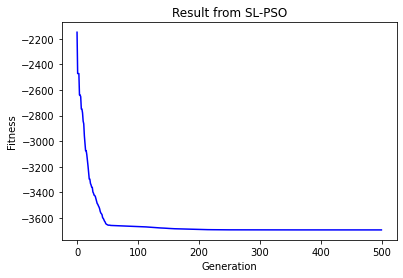

In [225]:
import operator
import random
import numpy
import math
from deap import base
from deap import benchmarks
from deap import creator
from deap import tools

posMinInit      = -500
posMaxInit      = +500
VMaxInit        = 1.5
VMinInit        = 0.5
dimension       = 20
interval        = 10
iterations      = 500
populationSize  = 100+int(dimension/10)

#variables used in SL-PSO
epsilon = dimension/100.0*0.01 # social influence of swarm centre


# function to get the mean positions of the inviduals (swarm centre)
def getcenter(pop):
    center=list()
    for j in range(dimension): # count through dimensions
        centerj = 0
        for i in pop: # for each particle
            centerj += i[j] # sum up position in dimention j
        centerj /= populationSize # Average
        center.append(centerj)
    return center


creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) # -1 is for minimise
creator.create("Particle", list, fitness=creator.FitnessMin, speed=list, smin=None, smax=None, best=None)
# particle rerpresented by list of 5 things
# 1. fitness of the particle, 
# 2. speed of the particle which is also going to be a list, 
# 3.4. limit of the speed value, 
# 5. best state the particle has been in so far.

def generate(size, smin, smax):
    part = creator.Particle(random.uniform(posMinInit, posMaxInit) for _ in range(size)) 
    part.speed = [random.uniform(VMinInit, VMaxInit) for _ in range(size)]
    part.smin = smin #speed clamping values
    part.smax = smax
    return part



def updateParticle(part,pop,center,i):
    r1 = random.uniform(0, 1)
    r2 = random.uniform(0, 1)
    r3 = random.uniform(0, 1)
    
    #Randomly choose a demonstrator for particle i from any of particles 0 to i-1, the Particle i 
    #updates its velocity by learning from the demonstrator and the mean position of the swarm
    demonstrator=random.choice(list(pop[0:i]))
    
    for j in range(dimension): # count through dimensions
        part.speed[j]=r1*part.speed[j]+r2*(demonstrator[j]-part[j])+r3*epsilon*(center[j]-part[j])
        part[j]=part[j]+part.speed[j]
        
    for i, speed in enumerate(part.speed):
        if abs(speed) < part.smin:
            part.speed[i] = math.copysign(part.smin, speed)
        elif abs(speed) > part.smax:
            part.speed[i] = math.copysign(part.smax, speed)

def eval_func(part):
    f=0
    for i in range(dimension):
        f+=(part[i]*math.sin(math.sqrt(abs(part[i]))))
    return (-f,)        
        
toolbox = base.Toolbox()
toolbox.register("particle", generate, size=dimension, smin=-15, smax=15)
toolbox.register("population", tools.initRepeat, list, toolbox.particle)
toolbox.register("update", updateParticle)
toolbox.register("evaluate", eval_func)

fitpar = [] #list of fitness values of best particle

def main():
    pop = toolbox.population(n=populationSize) # Population Size
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("std", numpy.std)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)
    
    #intialize the learning probabilities
    prob=[0]*populationSize
    for i  in range(len(pop)):
        prob[populationSize - i - 1] = 1 - i/(populationSize - 1)
        prob[populationSize - i - 1] = pow(prob[populationSize - i - 1], math.log(math.sqrt(math.ceil(dimension/100.0))))

    logbook = tools.Logbook()
    logbook.header = ["gen", "evals"] + stats.fields

    #begin main loop
    for g in range(iterations):

        for part in pop:
            part.fitness.values = toolbox.evaluate(part) #actually only one fitness value

        #Sort the individuals in the swarm in ascending order. i.e., particle 0 is the best
        pop.sort(key=lambda x: x.fitness, reverse=True)
        fitpar.append(pop[0].fitness.values)
        #calculate the center (mean value) of the swarm
        center = getcenter(pop)
        
        for i  in reversed(range(len(pop)-1)):  # start with worst particle, and go in reverse towards best
                                                # don't do element 0 (best). Hence the i+1 below.
            if random.uniform(0, 1)<prob[i+1]: #learning probability for that particle
                toolbox.update(pop[i+1],pop,center,i+1)

        # Gather all the fitnesses in one list and print the stats
        # print every interval
        if g%interval==0: # interval
            logbook.record(gen=g, evals=len(pop), **stats.compile(pop))
            print(logbook.stream)
    
    plt.plot(np.arange(0,iterations),fitpar,'b-')
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title("Result from SL-PSO")
    return pop, logbook

if __name__ == "__main__":
    main()



          x1        x2        x3            (f1, f2)
0  -1.818182 -0.394917 -1.153470   (4.1586, 24.2107)
1   0.035191  1.223851 -2.967742   (9.2339, 17.4204)
2  -2.162268 -3.632454 -1.036168   (4.7898, 29.9083)
3  -1.145650 -3.296188  2.443793   (1.7192, 39.8324)
4   3.710655  1.442815  3.382209   (4.1477, 34.5098)
5   2.310850  0.324536 -3.640274  (12.7794, 16.8777)
6  -2.647116 -1.333333 -0.598240   (3.9379, 27.8845)
7   0.739003 -3.601173 -2.091887   (6.3171, 25.2082)
8  -2.209189  2.709677  0.488759   (2.1879, 24.7824)
9   0.246334 -2.303030  2.529814   (1.0101, 37.3879)
10  2.091887 -0.887586 -0.512219   (2.1109, 23.3622)
11 -2.913001  3.038123 -3.945259   (16.566, 17.6678)
12  2.084066 -2.733138 -2.193548   (6.8557, 22.9138)
13 -1.747801 -3.726295 -1.051808    (4.4427, 29.546)
14 -1.857283 -1.137830 -0.989247   (3.8557, 25.7094)
15  2.084066 -2.107527 -3.874878    (14.012, 20.505)
16  3.460411 -2.717498  1.865103   (2.0771, 33.6731)
17 -2.154448  0.832845 -0.332356    (2.8441, 2

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


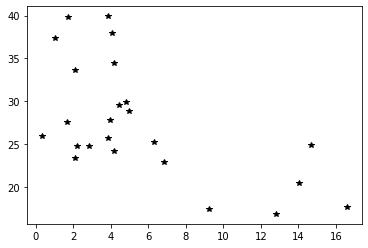

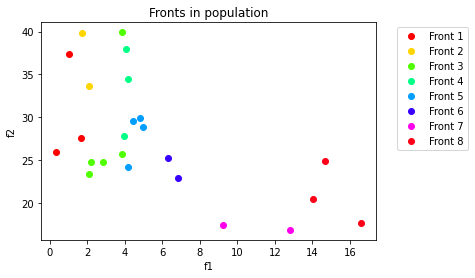

In [278]:
import random
import array
import random
import json
import numpy
import pandas as pd
from sympy.combinatorics.graycode import GrayCode
from sympy.combinatorics.graycode import random_bitstring, gray_to_bin, bin_to_gray
from deap import creator, base, tools, algorithms
from deap.benchmarks.tools import diversity, convergence, hypervolume

creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMin)

numofbits = 10  
dimension = 3   #number of decision variables
popSize   = 24  #population size

random.seed(10)

def eval_func(individual):
    sep = separatevariables(individual)
    f1 = (((sep[0]-0.6)/1.6)**2 + (sep[1]/3.4)**2 + (sep[2]-1.3)**2)/2
    f2 = (((sep[0]/1.9)-2.3)**2 + ((sep[1]/3.3)-7.1)**2 + (sep[2]+4.3)**2)/3
    F1 = round(f1, 4)
    F2 = round(f2, 4)
    return (F1,F2)

toolbox = base.Toolbox()
toolbox.register("gray_code", random_bitstring, numofbits) #gray code generator
toolbox.register("individual", tools.initRepeat, creator.Individual, 
    toolbox.gray_code, dimension)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", eval_func)


def chrom2real(c):
    numasint=int(c, 2) # convert to int from base 2 list
    numinrange=-4+8*numasint/1023  #maximum possible value with 10 bit strings
    return numinrange

def separatevariables(v):
    indasstring=''.join(map(str, v))
    v=gray_to_bin(indasstring)
    return chrom2real(v[0:numofbits]),chrom2real(v[numofbits:2*numofbits]),chrom2real(v[2*numofbits:])


pop = toolbox.population(n=popSize)

invalid_individuals = [ind for ind in pop if not ind.fitness.valid]
fitnesses = list(map(toolbox.evaluate, pop))
for ind, fit in zip(invalid_individuals, fitnesses):
    ind.fitness.values = fit


decod_values = []    #The decoded values from gray coded individuals
for i in range(24):
    decod_values.append((separatevariables(pop[i])))
    
table = pd.DataFrame(decod_values, columns = ["x1","x2","x3"])
table["f1","f2"] = fitnesses
print(table)  #table for question 3.1



x,y = map(list, zip(*fitnesses))
import matplotlib.pyplot as plt
plt.plot(x,y,'k*')
plt.show

# Efficient non-dominated sorting

def domicheck(ind, current_front):
    for ind in current_front[::-1]:
        for j in reversed(range(len(current_front))): 
            if (ind[1]<current_front[j][1]):
                return True
        return False

def front_classifier(ind, fronts):
    index = 0
    while True:
        current_front = fronts[index]
        dominated = domicheck(ind, current_front)
        if not dominated:
            fronts[index].append(ind)
            return fronts
        index += 1
        if index+1 > len(fronts):
            new_front = [ind]
            fronts.append(new_front)
            return fronts

fronts = [[]]
def efficient_NDsorting(fitnesses): 
    fitnesses_copy = toolbox.clone(fitnesses)
    fitnesses_copy.sort()
    fronts = [[fitnesses_copy[0]]]
    fitnesses_copy.pop(0)
    for ind in fitnesses_copy:
        fronts = front_classifier(ind, fronts)
    return fronts

fronts = efficient_NDsorting(fitnesses)
print("\n")

def front_finder(fit,fronts):
    for i in range(len(fronts)):
        for j in range(len(fronts[i])):
            if (fit==fronts[i][j]):
                return i+1
            else:
                continue
                
table1 = pd.DataFrame(decod_values, columns=["x1","x2","x3"])
table1["f1","f2"] = fitnesses  #a second table created for adding front number

front_list = []  #list of front numbers
for i in range(len(fitnesses)):
    front_list.append(front_finder(fitnesses[i],fronts))

table1["Front number"] = front_list
front_table = table1.sort_values(by = "Front number").reset_index(drop=True)
front_table.index = np.arange(0,len(front_table)) 
front_table.style.highlight_max(subset=["f1","f2"],color="red",axis=0) #highlight worst f1,f2 values
print(front_table) #table arranged in ascending order of front number

#2D plot of fronts with different colours
frontx = []  #list of f1 values
fronty = []  #list of f2 values
plt.figure()
plt.title("Fronts in population")
colours = iter(cm.hsv(np.linspace(0,1,len(fronts))))
for i in range(len(fronts)):
    for j in range(len(fronts[i])):
        frontx.append(fronts[i][j][0])
        fronty.append(fronts[i][j][1])
    plt.plot(frontx,fronty,'o',color=next(colours),label="Front %s"%(i+1))
    frontx = []
    fronty = []
plt.xlabel("f1")
plt.ylabel("f2")
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
plt.show()




